In [1]:
from __future__ import annotations

from dataclasses import dataclass
import enum


class Event(enum.IntEnum):
    DRAW1 = 1
    DRAW2 = 2
    DRAW3 = 3
    BET = 4
    CHECK = 5
    CALL = 6
    FOLD = 7


Player = int
Card = int


@dataclass(slots=True, frozen=True)
class InfoSet:
    player: Player
    card: Card
    history: tuple[Event, ...]

    def actions(self):
        if len(self.history) == 0:
            return (Event.CHECK, Event.BET, Event.FOLD)
        elif len(self.history) == 1:
            last = self.history[-1]
            if last == Event.BET:
                return (Event.CALL, Event.FOLD)
            elif last == Event.CHECK:
                return (Event.BET, Event.CHECK)
            raise ValueError
        else:
            assert len(self.history) == 2 and self.history == (Event.CHECK, Event.BET), self.history
            return (Event.CALL, Event.FOLD)


@dataclass(slots=True, frozen=True)
class OCP:
    history: tuple[Event, ...] = ()

    @property
    def terminal(self):
        if not self.history:
            return False
        
        last = self.history[-1]
        if last == Event.FOLD:
            return True
        elif last == Event.CALL:
            return len(self.history) >= 4
        elif last == Event.CHECK:
            return len(self.history) >= 4

        return False
    
    def payoff(self, player: Player):
        value = 1
        if Event.BET in self.history and Event.CALL in self.history:
            value = 2
        
        if Event.FOLD in self.history:
            ix = self.history.index(Event.FOLD)
            winner = 1 - (ix % 2)
            return value if winner == player else -value

        if self.history[0] < self.history[1]:
            value = -value
        
        if player == 1:
            value = -value
        
        return value

    @property
    def chance(self):
        return len(self.history) <= 1
    
    def chances(self) -> dict[Event, float]:
        chances = {Event.DRAW1: 1 / 3, Event.DRAW2: 1 / 3, Event.DRAW3: 1 / 3}
        if not self.history:
            return chances
        
        chances.pop(self.history[0])
        for k, v in chances.items():
            chances[k] = 1 / 2
        
        return chances

    @property
    def active(self) -> Player:
        return len(self.history) % 2

    def infoset(self, player: Player) -> InfoSet:
        return InfoSet(
            player=player,
            card=int(self.history[player]),
            history=self.history[2:],
        )
    
    def apply(self, event: Event) -> OCP:
        return OCP(self.history + (event,))

In [2]:
class RPSEvent(enum.IntEnum):
    ROCK = 0
    PAPER = 1
    SCISSORS = 2


@dataclass(slots=True, frozen=True)
class RPSInfoSet:
    player: int
    def actions(self):
        return (RPSEvent.ROCK, RPSEvent.PAPER, RPSEvent.SCISSORS)


@dataclass(slots=True, frozen=True)
class RPS:
    history: tuple[RPSEvent, ...] = ()

    @property
    def terminal(self):
        return len(self.history) == 2
    
    def payoff(self, player: Player):
        a, b = self.history

        if a == b:
            return 0

        value = 1
        if (
            a == RPSEvent.ROCK and b == RPSEvent.PAPER
            or a == RPSEvent.PAPER and b == RPSEvent.SCISSORS
            or a == RPSEvent.SCISSORS and b == RPSEvent.ROCK
        ):
            value = -1
        
        if player == 1:
            value = -value
        
        return value

    @property
    def chance(self):
        return False
    
    def chances(self) -> dict[Event, float]:
        raise NotImplementedError

    @property
    def active(self) -> Player:
        return len(self.history)

    def infoset(self, player: Player) -> InfoSet:
        return RPSInfoSet(player)

    def apply(self, event: Event) -> OCP:
        return RPS(self.history + (event,))

In [3]:
def matching(regrets):
    regrets = [max(0, r) for r in regrets]
    denom = sum(regrets)

    if denom > 0:
        return [r / denom for r in regrets]

    return [1 / len(regrets)] * len(regrets)


def walk(game, player, p0, p1, regrets, strategies, t):
    if p0 == p1 == 0:
        return 0

    if game.terminal:
        return game.payoff(player)

    if game.chance:
        value = 0
        for action, p in game.chances().items():
            p0p = p0 if player == 0 else p0 * p
            p1p = p1 if player == 1 else p1 * p
            value += p * walk(game.apply(action), player, p0p, p1p, regrets, strategies, t)
        return value

    infoset = game.infoset(game.active)
    actions = infoset.actions()

    if infoset not in regrets:
        regrets[infoset] = {action: 0 for action in actions}
    if infoset not in strategies:
        strategies[infoset] = {action: 0 for action in actions}

    R = regrets[infoset]
    S = strategies[infoset]

    strategy = matching(list(R.values()))
    cfs = {action: 0 for action in actions}
    value = 0

    for action, p in zip(actions, strategy):
        p0p = p0 * p if game.active == 0 else p0
        p1p = p1 * p if game.active == 1 else p1
        cf = walk(game.apply(action), player, p0p, p1p, regrets, strategies, t)

        cfs[action] = cf
        value += p * cf

    pi, pmi = p0, p1
    if player == 1:
        pi, pmi = p1, p0

    if game.active == player:
        for action, p in zip(actions, strategy):
            R[action] += pmi * (cfs[action] - value)
            S[action] += t * (pi * p)

    return value

In [28]:
from collections import defaultdict


regrets = defaultdict(lambda: defaultdict(int))
strategies = defaultdict(lambda: defaultdict(int))

In [31]:
for t in range(10000):
    for player in range(2):
        walk(OCP(), player, 1, 1, regrets, strategies, 1)

In [32]:
strategies

ss = {
    infoset: {action: p / sum(policy.values()) for action, p in policy.items()}
    for infoset, policy in strategies.items()
}
ss

{InfoSet(player=0, card=1, history=()): {<Event.CHECK: 5>: 0.39370382340455157,
  <Event.BET: 4>: 0.21005899212887452,
  <Event.FOLD: 7>: 0.39623718446657386},
 InfoSet(player=1, card=2, history=(<Event.CHECK: 5>,)): {<Event.BET: 4>: 4.950495049504951e-05,
  <Event.CHECK: 5>: 0.999950495049505},
 InfoSet(player=0, card=1, history=(<Event.CHECK: 5>, <Event.BET: 4>)): {<Event.CALL: 6>: 2.09569341012726e-05,
  <Event.FOLD: 7>: 0.9999790430658987},
 InfoSet(player=1, card=2, history=(<Event.BET: 4>,)): {<Event.CALL: 6>: 0.3383911669945626,
  <Event.FOLD: 7>: 0.6616088330054374},
 InfoSet(player=1, card=3, history=(<Event.CHECK: 5>,)): {<Event.BET: 4>: 0.9999009900990099,
  <Event.CHECK: 5>: 9.900990099009902e-05},
 InfoSet(player=1, card=3, history=(<Event.BET: 4>,)): {<Event.CALL: 6>: 0.9999752475247525,
  <Event.FOLD: 7>: 2.4752475247524754e-05},
 InfoSet(player=0, card=2, history=()): {<Event.CHECK: 5>: 0.99858637614905,
  <Event.BET: 4>: 0.0013971222007850609,
  <Event.FOLD: 7>: 1.6501

In [23]:
import random


def normalize(l: list[float]):
    s = sum(l)
    return [x / s for x in l]


def play(game, s1, s2):
    s = (s1, s2)

    while not game.terminal:
        if game.chance:
            chances = game.chances()
            event, = random.choices(list(chances.keys()), weights=list(chances.values()))
        else:
            infoset = game.infoset(game.active)
            policy = s[game.active][infoset]
            event, = random.choices(list(policy.keys()), weights=normalize(list(policy.values())))

        game = game.apply(event)
    
    return game.payoff(0)

In [24]:
v = 0
for _ in range(10000):
    v += play(OCP(), strategies, strategies)

v / 10000

-0.0307

In [16]:
def f(x, A, B):
    return (B - x) * (1 + A) / (B - A) / (1 + x)

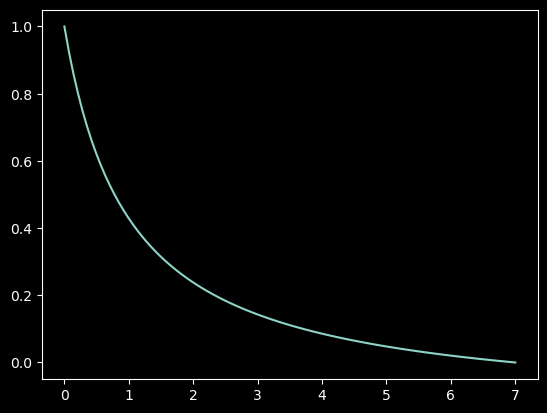

In [19]:
import matplotlib.pyplot as plt
import numpy as np


A = 0
B = 7
x = np.linspace(A, B, 100)
plt.plot(x, f(x, A, B))